In [1]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import imutils
# import some common libraries
import numpy as np
import os, json, cv2, random
import cv2 as cv
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

torch:  1.11 ; cuda:  1.11.0
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/1.11.0/torch1.11/index.html


In [2]:
import pytesseract
import argparse
import imutils
import cv2
import cv2 as cv
import re
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [70]:
def pltshow(imgzz):
    plt.imshow(cv2.cvtColor(imgzz, cv2.COLOR_BGR2RGB))
    
def eqhist(img):
    return cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

def getCanPipe(image, eqHist = False, blur = True, ):
    if eqHist:
        gray = eqhist(image)
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if blur:
        blurred = cv2.GaussianBlur(gray, (5, 5,), 0)
    else:
        blurred = gray
    edged = cv2.Canny(blurred, 100, 300)
    return edged

def sortCorners(corners):
    c = []
    idx = 0
    for i in corners.tolist():
        c.append(i[0])
        idx+=1
    c = sorted(c, key=lambda x:x[1])
    topones = [c[0], c[1]]
    bottomones = [c[2], c[3]]
    topones = sorted(topones, key = lambda x:x[0])
    topleft = topones[0]
    topright = topones[1]

    botones = sorted(bottomones, key = lambda x:x[0])
    bottomleft = botones[0]
    bottomright = botones[1]
    cornersz = [topleft, topright, bottomleft, bottomright]
    return cornersz

def getRect(edged):
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    receiptCnt = None
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            receiptCnt = approx
            # print(receiptCnt)
            break
    if receiptCnt is None:
        raise Exception(("No outline, oof"))
    return receiptCnt

def drawRect(image, rect):
    output = image.copy()
    cv2.drawContours(output, [rect], -1, (0, 255, 0), 2)
    pltshow(output)

def histeq(rgb_img):
    ycrcb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2YCrCb)
    ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])
    return cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)

def subtractMaskFromImg(img, mask1):
    mask2 = cv2.bitwise_not(mask1)
    return cv2.bitwise_and(img, img, mask = mask2)

def getMaskFromImg(img, mask):
    return cv2.bitwise_and(img, img, mask = mask)


def getTemplate(tempPath, originalImage, scalingFactor = 1):
    """
    return: i think just an image of the check
    """
    img = imutils.resize(originalImage, width = 500)
    img2 = img.copy()
    template = cv.imread(tempPath)
    wh = (int(329 * scalingFactor), int(162 * scalingFactor))
    template = cv2.resize(template, wh)
    w, h = (template.shape[-2], template.shape[-3])
    meth = ['cv.TM_SQDIFF']
    
    img = img2.copy()
    # method = eval(meth)
    res = cv.matchTemplate(img,template,0)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    top_left = min_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv.rectangle(mask,top_left, bottom_right, 255, -1)
    reverse = cv.bitwise_and(img, img, mask = mask)
    # pltshow(reverse)
    return reverse, mask

def approximateCorners(image, mask):
    ret,thresh = cv2.threshold(mask,127,255,0)
    cnt,hier = cv2.findContours(thresh, 0, 3)
    cnt = cnt[0]
    boo = False
    epsilon = 0.08*cv.arcLength(cnt,True)
    approx = cv.approxPolyDP(cnt,epsilon,False)
    contours = sorted([approx], key=cv2.contourArea, reverse=True)
    # find the perimeter of the first closed contour
    perim = cv2.arcLength(contours[0], True)
    # setting the precision
    epsilon = 0.02*perim
    # approximating the contour with a polygon
    approxCorners = cv2.approxPolyDP(contours[0], epsilon, True)
    # check how many vertices has the approximate polygon
    approxCornersNumber = len(approxCorners)
    return approxCorners

# Working shiz

In [4]:
plt.rcParams["figure.figsize"] = (15,15)

In [111]:
def getDetectronOutput(image, dilateBy = 1, iterations = 20):
    """
    1,1 if no person
    7, 20 if person
    returns a cropped inamge of the check
    """
    orig = image.copy()
    image = imutils.resize(orig, width = 500) ## if the image does not have any humans, resize, else dont
    ratio = orig.shape[1] / float(image.shape[1])

    imagec = histeq(image)

    cfg = get_cfg()
    cfg.MODEL.DEVICE='cpu'
    # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
    # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    predictor = DefaultPredictor(cfg)

    outputs = predictor(imagec)

    v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    peopleMasks = []
    bookMasks = []
    isABookMask = False
    isABookAndPersonMask = False
    temp = outputs["instances"]
    mask = None
    stillPeopleInThere = False

    if len(outputs["instances"].pred_classes) == 0: # nothing detected
        imagec = image
        isABookMask = True
    elif 73 in temp.pred_classes and 0 not in temp.pred_classes:
        # print("Skip me, go straight to the next step")
        imagec = image
        isABookMask = True
    elif 73 in temp.pred_classes and 0 in temp.pred_classes:  # assuming only one book in the image
        bookmask = np.array(temp.pred_masks[list(temp.pred_classes).index(73)])
        indices = bookmask.astype(np.uint8)  #convert to an unsigned byte
        indices*=255
        kernel = np.ones((dilateBy,dilateBy), np.uint8)
        img_dilation = cv2.dilate(indices, kernel, iterations=iterations)
        bookMask = getMaskFromImg(image, img_dilation)
        imagec = bookMask
        mask = img_dilation
        # imagec = getMaskFromImg(imagec, img_dilation)
        isABookAndPersonMask = True
    else:  # lots of people in the img
        # print("Lots of people")
        cntr = 0
        indices = None
        stillPeopleInThere = True
        for i in temp.pred_masks:
            kernel = np.ones((3,3), np.uint8)
            currClass = temp.pred_classes[cntr]
            if currClass == 0 or currClass == 27 or currClass == 58:
                if indices is None:
                    indices = np.array(i).astype(np.uint8)
                    indices = indices*255
                    indices = cv2.dilate(indices, kernel, iterations=1)
                else:
                    tempmask = np.array(i).astype(np.uint8)
                    tempmask = tempmask*255
                    tempmask = cv2.dilate(tempmask, kernel, iterations=1)
                    indices = indices + tempmask
            cntr+= 1
        mask = indices
        imagec = subtractMaskFromImg(image, indices)
    # print(imagec, out, temp.pred_classes, isABookMask)
    return imagec, out, temp.pred_classes, isABookMask, isABookAndPersonMask, stillPeopleInThere, mask, image

def correctPerspectiveAndOrientationGivenCheck(dst):
    smallCorners = getRect(getCanPipe(dst, eqHist=True))
    closestToBottomRight = sortCorners(smallCorners)[3]  # this is what we want to set as the top left
    H, W = dst.shape[:2]
    horLine = W/2
    verLine = H/2
    if closestToBottomRight[0] < horLine and closestToBottomRight[1] < verLine:  # top left
        dst = cv2.rotate(dst, cv2.ROTATE_90_CLOCKWISE)
    elif closestToBottomRight[0] < horLine and closestToBottomRight[1] > verLine:  # bottom left
        dst = cv2.rotate(dst, cv2.ROTATE_90_CLOCKWISE)
        dst = cv2.rotate(dst, cv2.ROTATE_90_CLOCKWISE)
    elif closestToBottomRight[0] > horLine and closestToBottomRight[1] > verLine:  # bottom right
        dst = cv2.rotate(dst, cv2.ROTATE_90_CLOCKWISE)
        dst = cv2.rotate(dst, cv2.ROTATE_90_CLOCKWISE)
        dst = cv2.rotate(dst, cv2.ROTATE_90_CLOCKWISE)
    return dst, smallCorners

def fitScreenToRect(image, corners):
    rows,cols,ch = image.shape
    H, W = image.shape[:2]
    pts1 = np.float32(sortCorners(corners))
    pts2 = np.float32([[0,0],[W,0],[0,H],[W,H]])
    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(image,M,(W,H))
    # dst = cv2.warpPerspective(image,M,(W + (W * 0.5),H))
    return dst

## Actual workflow

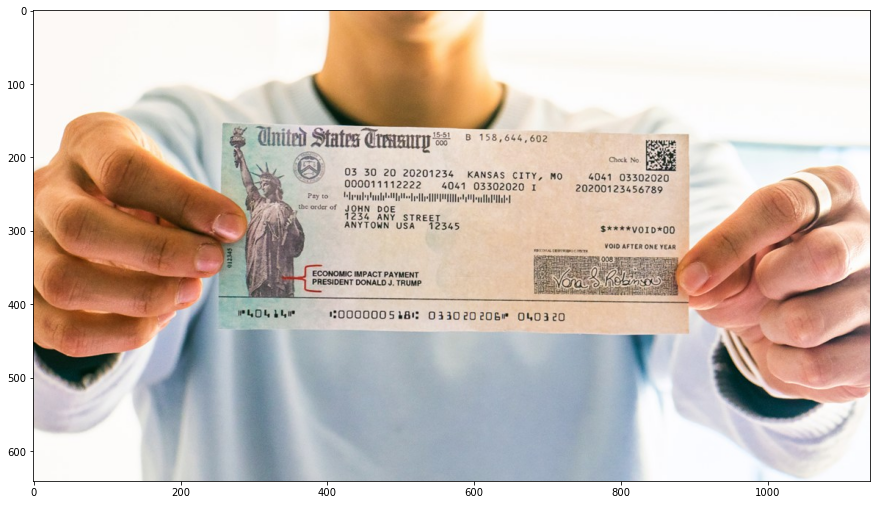

In [121]:
image = cv.imread("samples/check5.jpg")
ogog = image.copy()
templatePath = "samples/blankcheck2.jpg"
pltshow(image)

heheheh


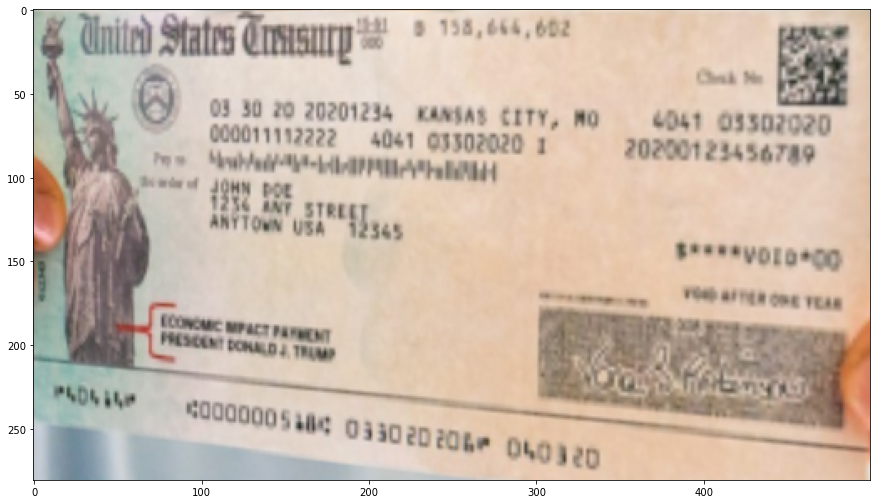

In [122]:
img, out, classes, isABookMask, isABookAndPersonMask, stillPeopleInThere, mask, reshapedImage = getDetectronOutput(ogog)
pltshow(out.get_image()[:, :, ::-1])
if not isABookMask and not isABookAndPersonMask:
    templatedImage, templateMask = getTemplate(templatePath, image)
    img, out, classes, isABookMask, isABookAndPersonMask, stillPeopleInThere, mask, image = getDetectronOutput(templatedImage, iterations = 1)
    if mask is None:
        templatedImage2, templateMask = getTemplate(templatePath, img, scalingFactor = 0.95)
        corners = approximateCorners(templatedImage2, templateMask)
        dst = fitScreenToRect(reshapedImage, corners)
    elif stillPeopleInThere:
        templatedImage2, templateMask = getTemplate(templatePath, img, scalingFactor = 0.5)
        corners = approximateCorners(templatedImage2, templateMask)
        dst = fitScreenToRect(reshapedImage, corners)
    else:
        print("heheheh")
        corners = approximateCorners(img, mask)
        dst = fitScreenToRect(reshapedImage, corners)
    pltshow(dst)
elif isABookAndPersonMask:
    # print("HI")
    corners = approximateCorners(reshapedImage, mask)
    dst = fitScreenToRect(reshapedImage, corners)
    pltshow(dst)
else:
    edged = getCanPipe(reshapedImage, eqHist = False)
    rect = getRect(edged)
    dst = fitScreenToRect(reshapedImage, rect)
    finImg, smallBox = correctPerspectiveAndOrientationGivenCheck(dst)
    pltshow(finImg)